# Mon premier réseau de neurones


Dans ce cours, nous allons construire notre premier réseau de neurones en utilisant la bibliothèque [micrograd](https://github.com/karpathy/micrograd/tree/master). Micrograd est une bibliothèque simple et facile à comprendre, spécialisée dans le calcul automatique des gradients. Pour mieux la maîtriser, vous pouvez regarder la [vidéo d'introduction](https://www.youtube.com/watch?v=VMj-3S1tku0&t=4s&ab_channel=AndrejKarpathy) d'Andrej Karpathy (en anglais).
Ce notebook s'inspire également du notebook fourni dans le dépôt de micrograd.

## Construction d'un réseau de neurones avec micrograd


In [1]:
#!pip install micrograd # uncomment to install micrograd
import random
import numpy as np 
import matplotlib.pyplot as plt
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

Pour construire un réseau de neurones, nous avons d'abord besoin d'un problème à résoudre. Nous utilisons pour cela la fonction [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) de scikit-learn, qui permet de générer un dataset.
Pour simplifier le calcul du loss dans les étapes suivantes, nous remplaçons les classes 0 et 1 par les classes -1 et 1.


### Initialisation du dataset


Les données d'entrée sont de la forme :  [-0.81882941  0.05879006]


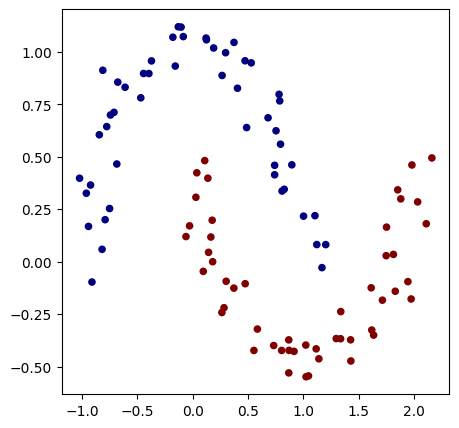

In [2]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1) # 100 éléments et un bruit Gaussien d'écart type 0.1 ajouté sur les données 

print("Les données d'entrée sont de la forme : ",X[1])

y = y*2 - 1 # Pour avoir y=-1 ou y=1 (au lieu de 0 et 1)

# Visualisation des données en 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### Création du réseau de neurones


Maintenant, nous allons initialiser notre réseau de neurones. Celui-ci prend 2 valeurs en entrée et doit produire un label -1 ou 1.
Le réseau que nous allons construire possède 2 couches cachées, chacune contenant 16 neurones. Chaque neurone fonctionne comme une régression logistique, ce qui fait de notre réseau un assemblage non linéaire de plusieurs régressions logistiques.

Voici un aperçu de l'architecture de ce réseau :

![Mlp](./images/Mlp.png)


In [3]:
# Initialisation du modèle 
model = MLP(2, [16, 16, 1]) # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
Nombre de paramètres 337


### Descente de gradient stochastique (SGD)


Avant de continuer, faisons un point sur la descente de gradient stochastique (SGD).
Pour appliquer l'algorithme de descente de gradient sur un dataset de taille $N$, il faudrait en théorie calculer la perte et le gradient sur chaque élément avant de mettre à jour les poids. Cette méthode garantit une diminution de la perte à chaque itération, mais elle est très coûteuse pour des datasets où $N$ est grand (souvent $N>10⁶$). De plus, il faudrait stocker les gradients de tous les $N$ éléments en mémoire, ce qui est impossible pour de grands ensembles de données.

Pour résoudre ce problème, nous utilisons des *mini-batch*, qui sont des groupes d'échantillons du dataset. L'optimisation se fait comme pour la descente de gradient classique, mais la mise à jour des poids se fait à chaque *mini-batch* (donc plus fréquemment). Cela rend le processus d'optimisation plus rapide et permet de traiter de grandes quantités de données. La taille d'un *mini-batch* est appelée *batch size* et sa valeur est souvent 16, 32 ou 64.
Pour en savoir plus sur la descente de gradient stochastique, consultez [Wikipedia](https://fr.wikipedia.org/wiki/Algorithme_du_gradient_stochastique) ou ce [blogpost](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31).

Définissons en Python une fonction pour récupérer *batch_size* éléments aléatoires de notre dataset.


In [4]:
def get_batch(batch_size=64):
  ri = np.random.permutation(X.shape[0])[:batch_size]
  Xb, labels = X[ri], y[ri]
  #inputs = [list(map(Value, xrow)) for xrow in Xb] # OLD
  # Conversion des inputs en Value pour pouvoir utiliser micrograd
  inputs = [list([Value(xrow[0]),Value(xrow[1])]) for xrow in Xb]
  return inputs,labels

### Fonction de perte


Pour entraîner notre réseau de neurones, nous devons définir une fonction de perte (*loss*). Dans notre cas, nous avons deux classes et nous voulons maximiser la marge entre les exemples appartenant à des classes différentes. Contrairement à la perte de log-vraisemblance négative utilisée précédemment, nous cherchons à maximiser cet écart, ce qui rend notre méthode plus robuste aux nouveaux éléments.

Nous utilisons le *loss max-margin* (marge maximale), défini par :
$\text{loss} = \max(0, 1 - y_i \cdot \text{score}_i)$


In [5]:
def loss_function(scores,labels):
  # La fonction .relu() prend le maximum entre 0 et la valeur de 1 - yi*scorei
  losses = [(1 - yi*scorei).relu() for yi, scorei in zip(labels, scores)]
  # On divise le loss par le nombre d'éléments du mini-batch
  data_loss = sum(losses) * (1.0 / len(losses))
  return data_loss

### Entraînement du modèle


Maintenant que nous avons les éléments clés de l'entraînement, il est temps de définir notre boucle d'entraînement


In [6]:
# Définissons nos hyper-paramètres d'entraînement 
batch_size=128
iteration=50

On peut maintenant lancer l'entraînement de notre modèle :


In [7]:
for k in range(iteration):
    
  # On récupère notre mini-batch random
  inputs,labels=get_batch(batch_size=batch_size)

  # On fait appel au modèle pour calculer les scores Y
  scores = list(map(model, inputs))
  
  # On calcule le loss
  loss=loss_function(scores,labels)


  accuracy = [(label > 0) == (scorei.data > 0) for label, scorei in zip(labels, scores)]
  accuracy=sum(accuracy) / len(accuracy)
  
  # Remise à zéro de valeurs de gradients avant de les calculer
  model.zero_grad() 
  # Calcul des gradients grâce à l'autograd de micrograd
  loss.backward() 
  
  # Mise à jour des poids avec les gradients calculés (SGD)
  learning_rate = 1.0 - 0.9*k/100 # On diminue le learning rate au fur et à mesure de l'entraînement
  for p in model.parameters():
      p.data -= learning_rate * p.grad
  
  if k % 1 == 0:
      print(f"step {k} loss {loss.data}, accuracy {accuracy*100}%")

step 0 loss 0.8862514464368221, accuracy 50.0%
step 1 loss 1.7136790633950052, accuracy 81.0%
step 2 loss 0.733396126728699, accuracy 77.0%
step 3 loss 0.7615247055858604, accuracy 82.0%
step 4 loss 0.35978083334534205, accuracy 84.0%
step 5 loss 0.3039360355411295, accuracy 86.0%
step 6 loss 0.2716587340549048, accuracy 89.0%
step 7 loss 0.25896576803013205, accuracy 91.0%
step 8 loss 0.2468445503533517, accuracy 91.0%
step 9 loss 0.26038987927745966, accuracy 91.0%
step 10 loss 0.23569710047306525, accuracy 91.0%
step 11 loss 0.2403768930229477, accuracy 92.0%
step 12 loss 0.20603128479123115, accuracy 91.0%
step 13 loss 0.22061157796029193, accuracy 93.0%
step 14 loss 0.19010711228374735, accuracy 92.0%
step 15 loss 0.21687609382796402, accuracy 93.0%
step 16 loss 0.18642445342175254, accuracy 92.0%
step 17 loss 0.2064478196088666, accuracy 92.0%
step 18 loss 0.15299793102189654, accuracy 94.0%
step 19 loss 0.18164592701596197, accuracy 93.0%
step 20 loss 0.15209012673698674, accura

Comme vous pouvez le constater, le *loss* ne diminue pas systématiquement à chaque étape d'entraînement. Cela s'explique par la descente de gradient stochastique : le fait de ne pas prendre en compte l'ensemble des données à chaque itération introduit une part d'aléatoire. Cependant, le *loss* diminue en moyenne au cours de l'entraînement, ce qui permet d'obtenir un modèle robuste plus rapidement.


(-1.548639298268643, 1.951360701731357)

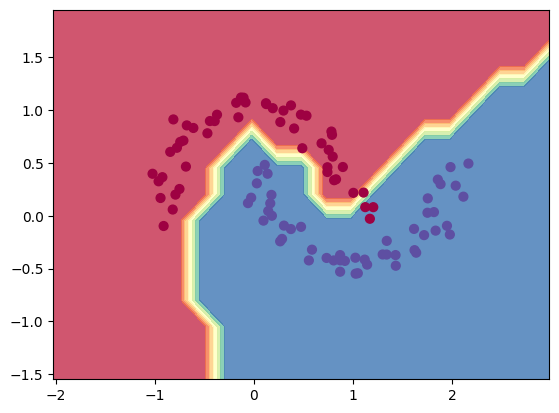

In [8]:
# Visualisation de la frontière de décision 
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())